In [1]:
import numpy as np
import xgboost as xgb

from skimage import io
from sklearn.metrics import jaccard_score, auc, roc_curve, precision_recall_curve


import matplotlib.pyplot as plt
import PIL

In [2]:
# Increase the limit of allowed images size
PIL.Image.MAX_IMAGE_PIXELS = 10e10

In [3]:
# Set the lame names
lame = "12AG01290_26"
label = "Tumor"

In [4]:
# Load the image
img = io.imread(f'data/{lame}/results/images_aligned/PANCKm-CD8r.ome.tiff')

# Load the lebel binary mask
mask_original = io.imread(f'data/{lame}/results/masks/PANCKm-CD8r_{label}_mask.png')

In [5]:
# Load the model file
model = xgb.Booster()
model.load_model(f"models/xgboost_{label}_model.model")

# Set the model to use GPU
model.set_param({'device':'gpu'})

In [6]:
# Define the center and size of the tile
center = (50000, 50000)
size = 10000

# Take a tile from the image
img_tile = img[center[0]-size//2:center[0]+size//2,
               center[1]-size//2:center[1]+size//2]

mask_tile = mask_original[center[0]-size//2:center[0]+size//2,
                          center[1]-size//2:center[1]+size//2]

In [7]:
# pridict the image using the model
dtest = xgb.DMatrix(img_tile.reshape(-1, 3))
y_score = model.predict(dtest)

In [10]:
# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(mask_tile.flatten(), y_score)

# Compute the AUC
auc_score = auc(recall, precision)

# calculate the closest threshold to the AUC
best_threshold = thresholds[np.argmin(np.abs(recall - precision))]

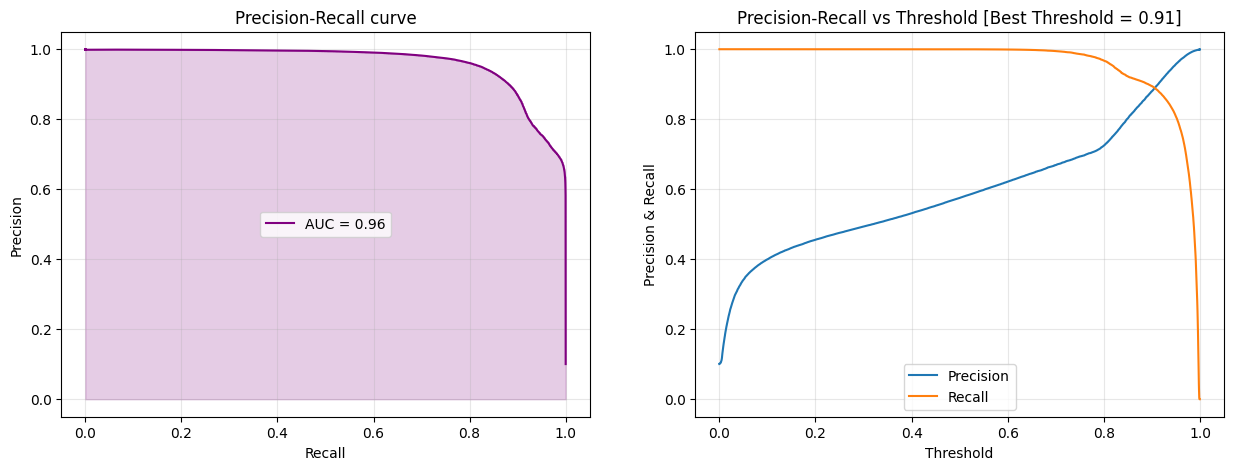

In [17]:
# Plot the precision-recall curve
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(recall, precision, color="purple", label=f"AUC = {auc_score:.2f}")
ax[0].fill_between(recall, precision, alpha=0.2, color="purple")
ax[0].set_xlabel("Recall")
ax[0].set_ylabel("Precision")
ax[0].set_title(f"Precision-Recall curve")
ax[0].grid(alpha=0.3)
ax[0].legend()

ax[1].plot(thresholds, precision[:-1], label="Precision")
ax[1].plot(thresholds, recall[:-1], label="Recall")
ax[1].set_xlabel("Threshold")
ax[1].set_ylabel("Precision & Recall")
ax[1].set_title(f"Precision-Recall vs Threshold [Best Threshold = {best_threshold:.2f}]")
ax[1].grid(alpha=0.3)
ax[1].legend()

plt.show()

In [13]:
# Binarize the mask using a threshold
mask_tile_pred = y_score.reshape(img_tile.shape[0], img_tile.shape[1]) > best_threshold

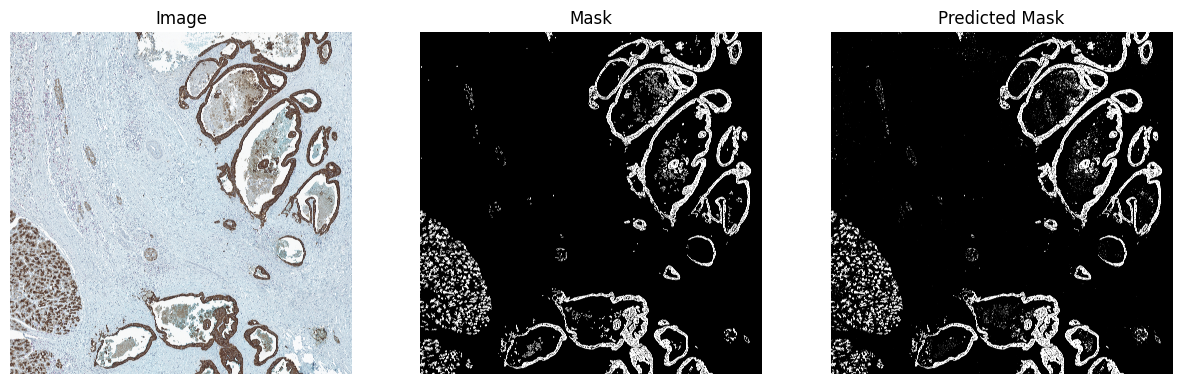

In [18]:
# Plot the mask and the predicted mask
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img_tile)
ax[0].set_title('Image')
ax[0].axis('off')

ax[1].imshow(mask_tile, cmap='gray')
ax[1].set_title('Mask')
ax[1].axis('off')

ax[2].imshow(mask_tile_pred, cmap='gray')
ax[2].set_title('Predicted Mask')
ax[2].axis('off')
plt.show()

In [19]:
# Compute the intersection over union
iou = jaccard_score(mask_tile.flatten(), mask_tile_pred.flatten())

print(f"IoU: {iou:.2f}")

IoU: 0.80


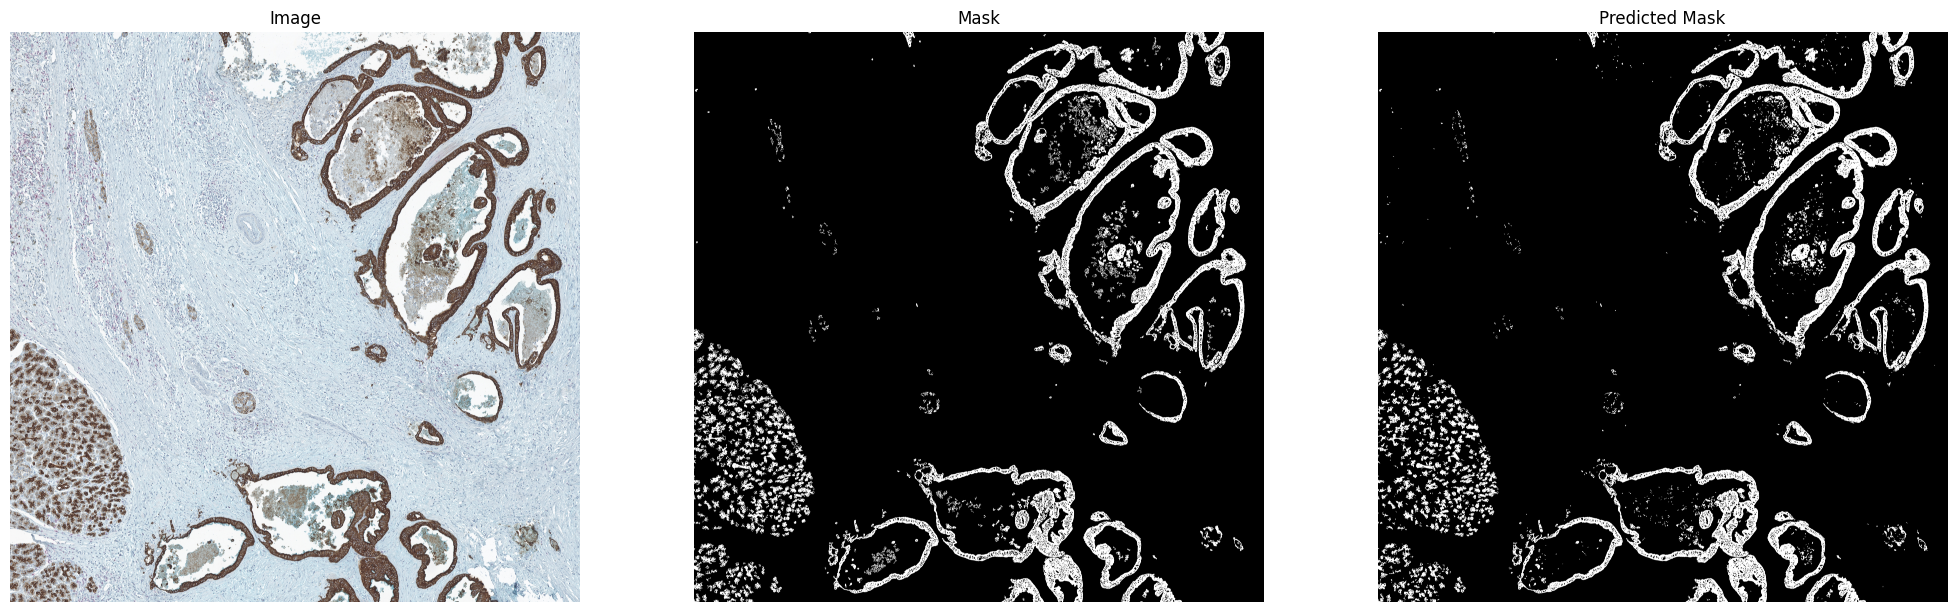

In [24]:
# Clean the mask from small objects
import skimage.morphology as morph

mask_tile_pred_clean = morph.remove_small_objects(mask_tile_pred, min_size=100)

# Plot the mask and the predicted mask
fig, ax = plt.subplots(1, 3, figsize=(25, 15))
ax[0].imshow(img[center[0]-size//2:center[0]+size//2,
                 center[1]-size//2:center[1]+size//2])
ax[0].set_title('Image')
ax[0].axis('off')

ax[1].imshow(mask_original[center[0]-size//2:center[0]+size//2,
                            center[1]-size//2:center[1]+size//2], cmap='gray')
ax[1].set_title('Mask')
ax[1].axis('off')

ax[2].imshow(mask_tile_pred_clean, cmap='gray')
ax[2].set_title('Predicted Mask')
ax[2].axis('off')
plt.show()

In [25]:
# Compute the intersection over union
iou = jaccard_score(mask_tile.flatten(), mask_tile_pred_clean.flatten())

print(f"IoU: {iou:.2f}")

IoU: 0.81
